In [374]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [375]:
########################################################

'Attrition' - Yes, No предсказываем

1) Нужно весть препоцесс в одну функцию засунуть, чтобы он работал на что угодно.

Loading dataset.

In [376]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# df_train[0:15]

This function transforms all the data into numerical values

In [377]:
def data_renaming(df, renames_dict, features=None):
    if features is None:
        df = df.replace({**renames_dict})
    else:
        for i, feature in enumerate(features):
            df[feature] = df[feature].replace({**renames_dict[i]})
    return   df

Let's first put all

Preprocessing data: converting all string values into numerical values.

In [378]:
features = [
    'BusinessTravel',  # 1
    'Department',  # 2
    'EducationField',  # 3
    'Gender',  # 4
    'JobRole',  # 5
    'MaritalStatus',  # 6
    'OverTime',  # 7
]
renames = [
    {'Travel_Rarely': 0.5, 'Travel_Frequently': 1, 'Non-Travel': 0},  # 1
    {'Cardiology': 0, 'Maternity': 1, 'Neurology': 2},  # 2
    {'Life Sciences': 0, 'Medical': 1, 'Marketing': 2, 'Technical Degree': 3,
     'Human Resources': 4, 'Other': 5},  # 3
    {'Male': 0, 'Female': 1},  # 4
    {'Nurse': 1, 'Other': 0, 'Therapist': 2, 'Administrative': 3, 'Admin': 4},  # 5
    {'Married': 0, 'Single': 1, 'Divorced': 2},  # 6
    {'No': 0, 'Yes' : 1},  # 7
]
data_train_num = data_renaming(df_train, renames, features)
data_train_num = data_renaming(data_train_num, [{'No': 0, 'Yes' : 1}], ['Attrition'])
data_test_num = data_renaming(df_test, renames, features)

Relocating all "non-numerical feature" (features with multiple choices and not numerical values)
to the end of the data base to make it easier to process later.

In [379]:
def features_move_to_end(data, features):
    new_data = data[[c for c in data if c not in features] + features]
    return new_data

features_end = [
    'Department',  # 2
    'EducationField',  # 3
    'JobRole',  # 5
    'MaritalStatus',  # 6
]
data_train_num_sort = features_move_to_end(data_train_num, features_end)
data_test_num_sort = features_move_to_end(data_test_num, features_end)

Deleting ['Over18', 'EmployeeCount', 'StandardHours']  since they carry 0 info (all the same).

In [380]:
def delete_useless_data(data, features):
    return data.drop(features, axis=1)

features_delete = ['Over18', 'EmployeeCount', 'StandardHours']
data_train_num_useful = delete_useless_data(data_train_num_sort, features_delete)
data_test_num_useful = delete_useless_data(data_test_num_sort, features_delete)

Rescaling all the features into [0, 1] diapason.

In [381]:
from sklearn.preprocessing import MinMaxScaler

def rescaler_data(data, data_train, range=(0,1)):
    min_max_scaler = MinMaxScaler(feature_range=range)
    min_max_scaler.fit(data_train)
    return min_max_scaler.transform(data)

X_train_num_useful = data_train_num_useful.drop('Attrition', axis=1)
y_train = data_train_num_useful['Attrition']
X_train = rescaler_data(X_train_num_useful, X_train_num_useful)
X_test = rescaler_data(data_test_num_useful, X_train_num_useful)
print(X_test)

[[0.70043927 0.57142857 0.5        ... 0.2        0.25       1.        ]
 [0.73527667 0.26190476 0.5        ... 0.         0.         0.5       ]
 [0.57519093 0.47619048 0.         ... 0.         0.25       0.        ]
 ...
 [0.712923   0.26190476 0.5        ... 0.4        0.         1.        ]
 [0.61017463 0.38095238 0.         ... 0.4        0.25       0.        ]
 [0.12573255 0.45238095 0.5        ... 0.2        0.         0.        ]]


Looking at the correlations between different features.

In [382]:
print(np.abs(np.corrcoef(X_train.T)[0][1:]).max())

0.06947372341147388


Plotting ROC curves for all the individual features.

#0: 0.5230563588047652), score=0.8813432835820896
#1: 0.749817604737484), score=0.8813432835820896
#2: 0.5551286352574036), score=0.8813432835820896
#3: 0.5507857641163283), score=0.8813432835820896
#4: 0.5883219103307611), score=0.8813432835820896
#5: 0.5284882761118124), score=0.8813432835820896
#6: 0.5987836765559514), score=0.8813432835820896
#7: 0.508744321782521), score=0.8813432835820896
#8: 0.5296731796420261), score=0.8813432835820896
#9: 0.6234855867802044), score=0.8813432835820896
#10: 0.7162808407755926), score=0.8813432835820896
#11: 0.5650099318880173), score=0.8813432835820896
#12: 0.737193722407724), score=0.8813432835820896
#13: 0.5297956640518908), score=0.8813432835820896
#14: 0.5), score=0.8813432835820896
#15: 0.7290618226745269), score=0.8813432835820896
#16: 0.5148738676848849), score=0.8813432835820896
#17: 0.5043029305726412), score=0.8813432835820896
#18: 0.5357148562938348), score=0.8813432835820896
#19: 0.6567507548767434), score=0.8813432835820896
#20: 0.7

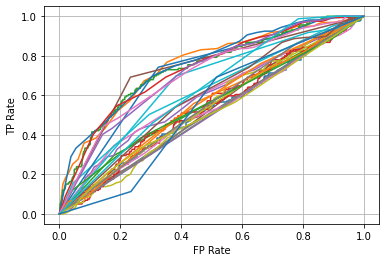

In [383]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# algorithm starting here
auc_value = []
# print(X_train)
for i, x_train in enumerate(np.array(X_train).T):
    x_train  = x_train.reshape(-1, 1)
    # print(x_train)
    log_reg = LogisticRegression(random_state=0, penalty='l1', solver='liblinear').fit(x_train, np.array(y_train))
    y_pred = log_reg.predict_proba(x_train)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train, dtype=int),  y_pred)
    auc = metrics.roc_auc_score(y_train, y_pred)
    auc_value.append(auc)
    # predict = log_reg.predict(x_train)
    # print(predict[predict != 0])
    print(f'#{i}: {auc}), score={log_reg.score(x_train, np.array(y_train))}')
    plt.plot(fpr,tpr)
    plt.ylabel('TP Rate')
    plt.xlabel('FP Rate')
print(auc_value)
plt.grid(True)
plt.show()

# good: 1, (9), 10, 12, 15, (19), 20, 23, 24, 26, (29)

In [384]:
good = [1, 10, 12, 15, 20, 23, 24, 26]
print(X_train)
log_reg = LogisticRegression(random_state=0).fit(X_train.T[good].T, np.array(y_train))
log_reg.score(X_train.T[good].T, np.array(y_train))
prediction = log_reg.predict(X_test.T[good].T)
print(prediction)
# log_reg.score(X_test.T[good].T)

[[0.33895688 0.52380952 0.5        ... 0.         0.75       0.        ]
 [0.60728912 0.52380952 0.5        ... 0.6        0.         1.        ]
 [0.22091939 0.16666667 0.5        ... 0.2        0.         0.        ]
 ...
 [0.73653886 0.26190476 0.5        ... 0.         0.         0.        ]
 [0.86914553 0.21428571 0.5        ... 0.         0.25       0.5       ]
 [0.96449261 0.21428571 0.5        ... 0.2        0.25       0.5       ]]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 

In [385]:
from sklearn.ensemble import RandomForestClassifier
good = [1, 10, 12, 15, 20, 23, 24, 26]
print(X_train)
log_reg = RandomForestClassifier(random_state=0).fit(X_train.T[good].T, np.array(y_train))
log_reg.score(X_train.T[good].T, np.array(y_train))
prediction = log_reg.predict(X_test.T[good].T)
print(prediction)

[[0.33895688 0.52380952 0.5        ... 0.         0.75       0.        ]
 [0.60728912 0.52380952 0.5        ... 0.6        0.         1.        ]
 [0.22091939 0.16666667 0.5        ... 0.2        0.         0.        ]
 ...
 [0.73653886 0.26190476 0.5        ... 0.         0.         0.        ]
 [0.86914553 0.21428571 0.5        ... 0.         0.25       0.5       ]
 [0.96449261 0.21428571 0.5        ... 0.2        0.25       0.5       ]]
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 

In [386]:
from sklearn.ensemble import AdaBoostClassifier
good = [1, 10, 12, 15, 20, 23, 24, 26]
print(X_train)
log_reg = AdaBoostClassifier(random_state=0).fit(X_train.T[good].T, np.array(y_train))
log_reg.score(X_train.T[good].T, np.array(y_train))
prediction = log_reg.predict(X_test.T[good].T)
print(prediction)

[[0.33895688 0.52380952 0.5        ... 0.         0.75       0.        ]
 [0.60728912 0.52380952 0.5        ... 0.6        0.         1.        ]
 [0.22091939 0.16666667 0.5        ... 0.2        0.         0.        ]
 ...
 [0.73653886 0.26190476 0.5        ... 0.         0.         0.        ]
 [0.86914553 0.21428571 0.5        ... 0.         0.25       0.5       ]
 [0.96449261 0.21428571 0.5        ... 0.2        0.25       0.5       ]]
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 

In [387]:
def result_file(prediction, name):
    example = pd.read_csv('sample_submission.csv')
    example['Predicted'] = prediction
    print(name)
    example.to_csv(name + '.csv', index=False)

In [388]:
result_file(prediction, 'prediction_RF_2')
print(prediction)

prediction_RF_2
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0]
